In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import py21cmfast as p21c
import h5py
import powerbox
from scipy import interpolate

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
outputs_dir = "/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"

bkg_fn = f"{outputs_dir}/bkg/LightCones/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
inj_small_fn = f"{outputs_dir}/xc/phot_decay_m5e3_lt1e28_d128/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"
#inj_large_fn = f"{outputs_dir}/inhom-hom-cmp/inhom_phot_m5e3_lt1e26_stdastro/LightCones/Lightcone_I0_D0.h5"
inj_large_fn = f"{outputs_dir}/xc/phot_decay_m5e3_lt1e26_d128/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_DM_1_r54321.h5"

In [3]:
lc_bkg = p21c.LightCone.read(bkg_fn)
lc_small = p21c.LightCone.read(inj_small_fn)
lc_large = p21c.LightCone.read(inj_large_fn)

In [4]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = powerbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

BOX_LEN = 256
HII_DIM = 128

k_fundamental = 2*np.pi / BOX_LEN
k_max = k_fundamental * HII_DIM
Nk = np.floor(HII_DIM).astype(int)

def get_chunk_indices(brightness_temp, nchunks):
    return list(range(0,brightness_temp.n_slices,round(brightness_temp.n_slices / nchunks),))

def powerspectra(brightness_temp, n_psbins=50, nchunks=20, min_k=0.1, max_k=1.0, logk=True):
    data = []
    chunk_indices = get_chunk_indices(brightness_temp, nchunks)
    
    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k ** 3 / (2 * np.pi ** 2)})
    return data

In [5]:
ps_bkg = powerspectra(lc_bkg, min_k=k_fundamental, max_k=k_max)
ps_small = powerspectra(lc_small, min_k=k_fundamental, max_k=k_max)
ps_large = powerspectra(lc_large, min_k=k_fundamental, max_k=k_max)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in divide
  np.bincount(


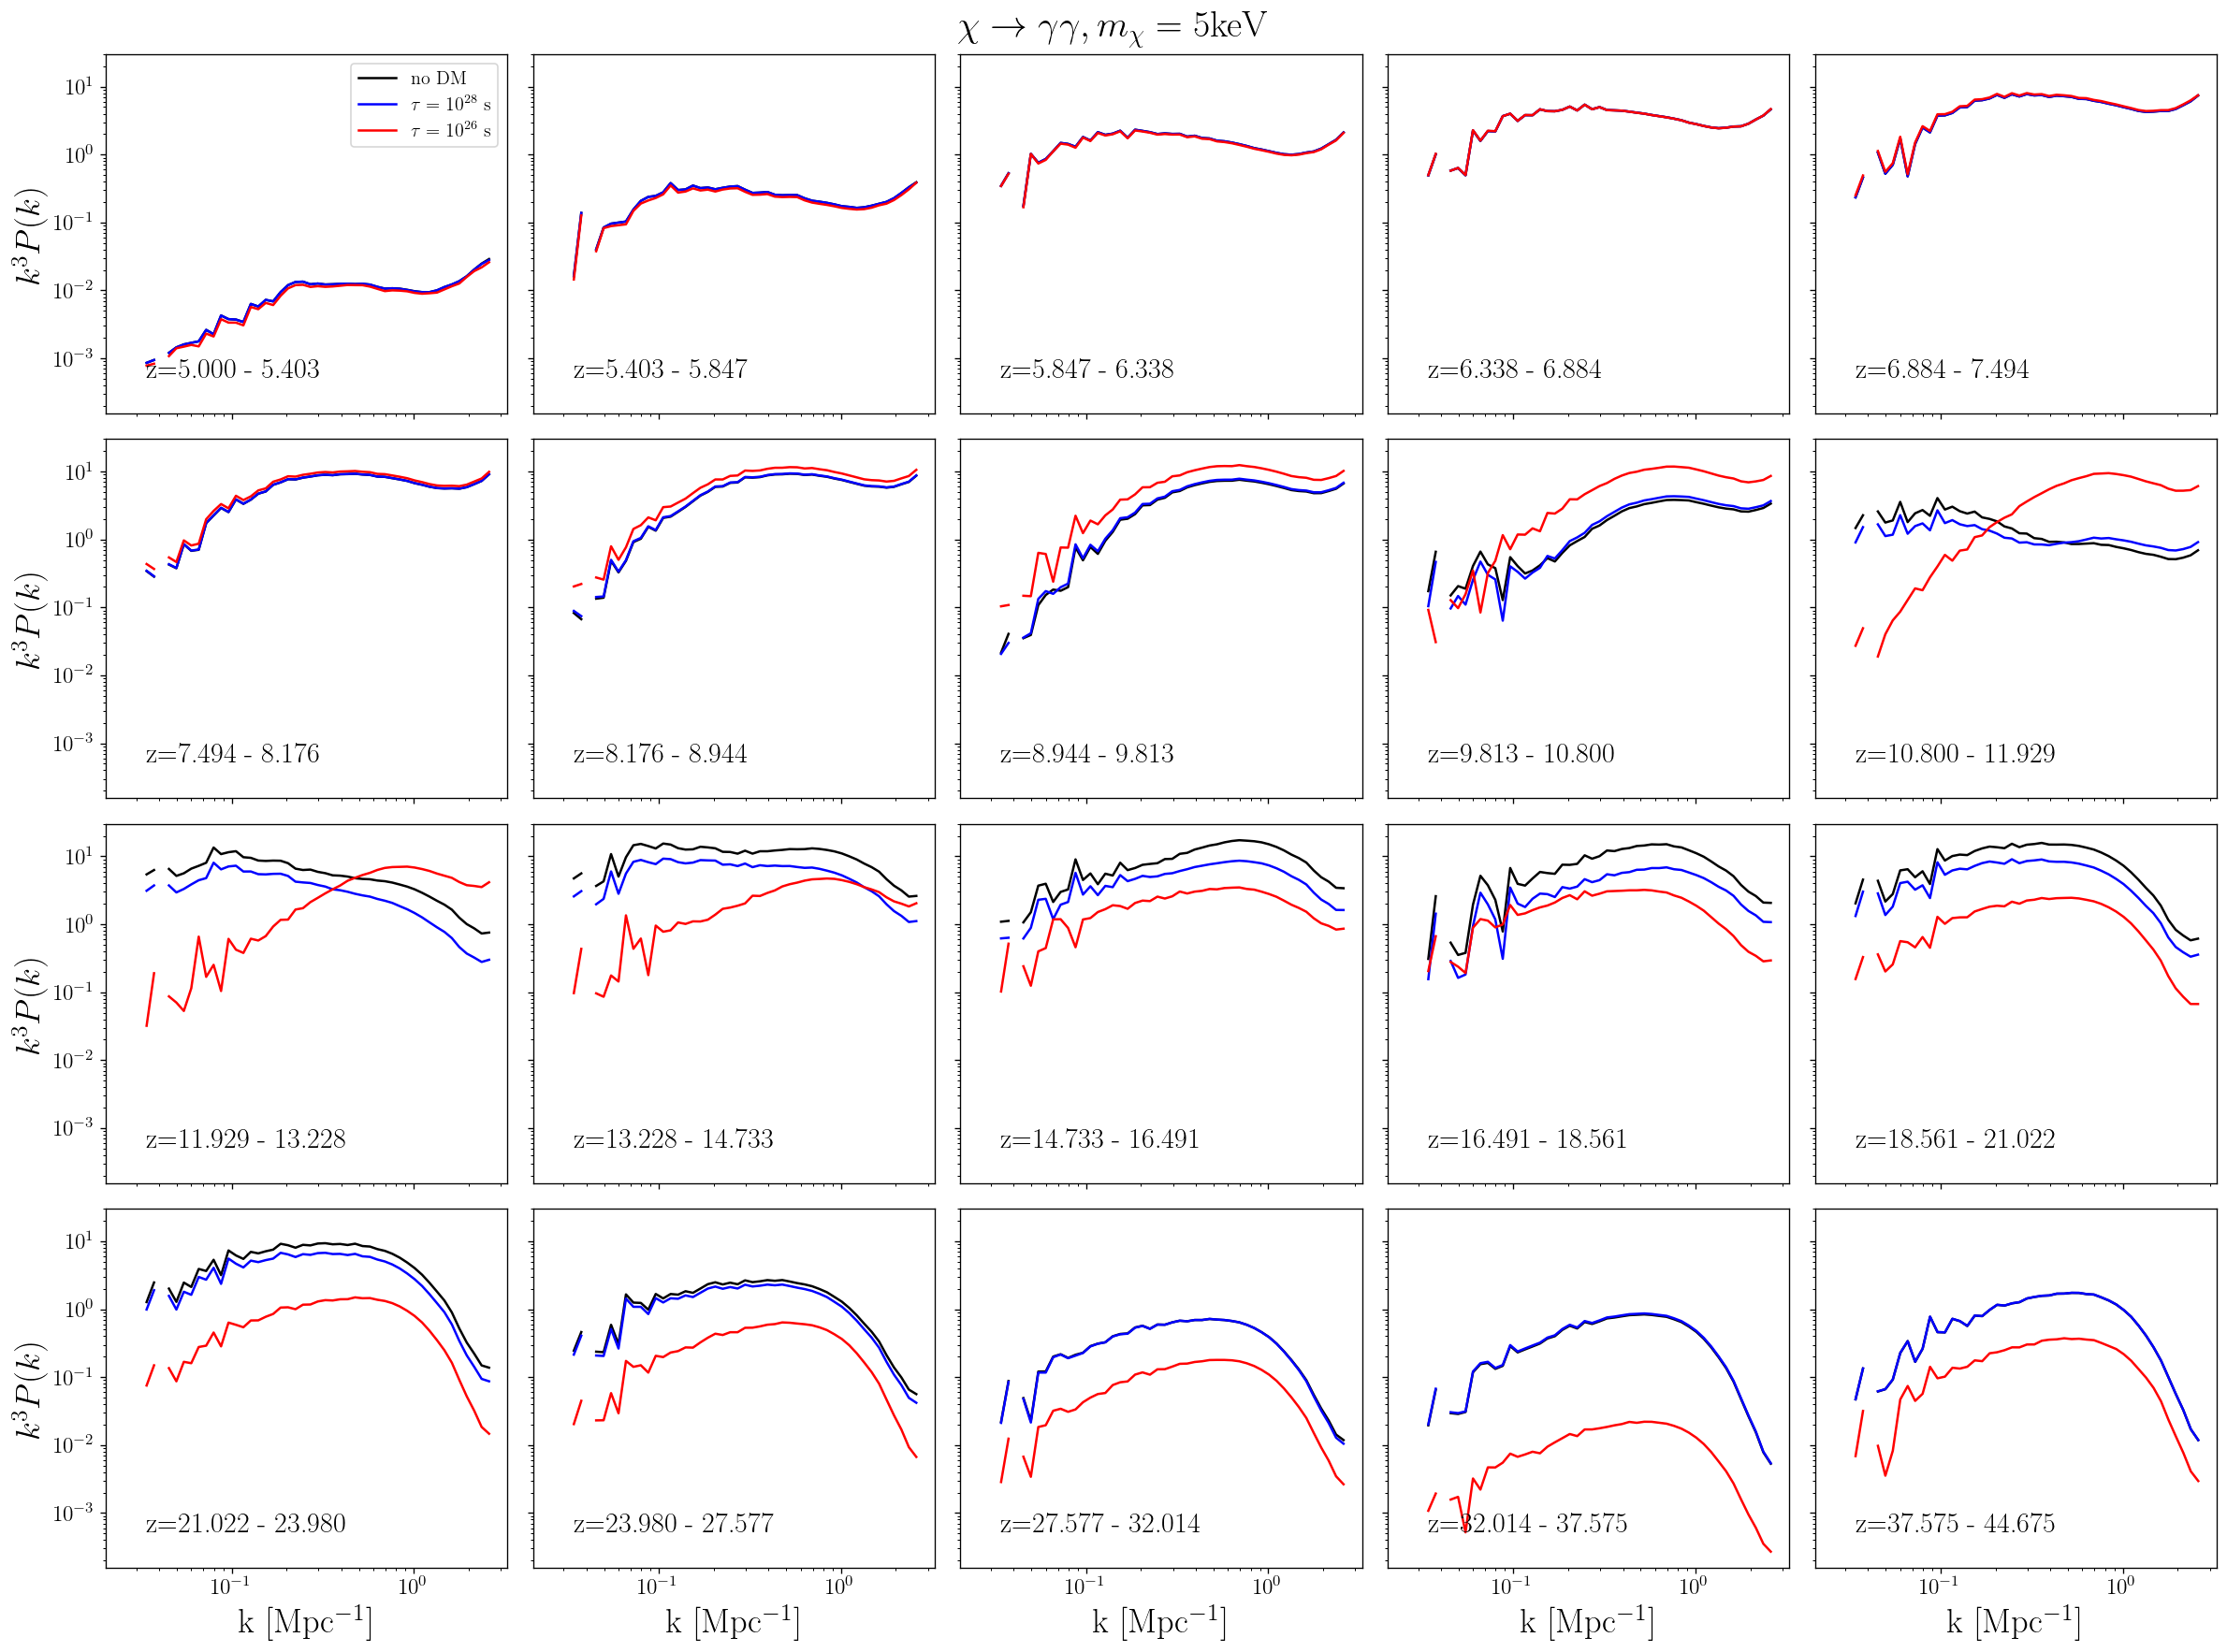

In [6]:
fig, axs = plt.subplots(4, 5, figsize = (20, 15), sharex = True, sharey = True)

chunk_inds = get_chunk_indices(lc_bkg, 20)
z_s = lc_bkg.lightcone_redshifts

for i, (ps, pss, psl) in enumerate(zip(ps_bkg, ps_small, ps_large)):
    ri, ci = np.unravel_index(i, axs.shape)
    ax = axs[ri, ci]

    ax.plot(ps['k'], ps['delta'], color='k', label='no DM' if i==0 else None)
    ax.plot(pss['k'], pss['delta'], color='b', label=r'$\tau=10^{28}$ s' if i==0 else None)
    ax.plot(psl['k'], psl['delta'], color='r', label=r'$\tau=10^{26}$ s' if i==0 else None)
    ax.set(xscale='log', yscale='log')

    ax.text(.1, .1, f'z={z_s[chunk_inds[i]]:.3f} - {z_s[chunk_inds[i+1]]:.3f}', transform=ax.transAxes, fontsize=18)

axs[0,0].legend()

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel('k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel('$k^3 P(k)$', fontsize = 22)
    
fig.suptitle(r'$\chi\rightarrow\gamma\gamma, m_\chi=5$keV', fontsize=24)
fig.tight_layout();

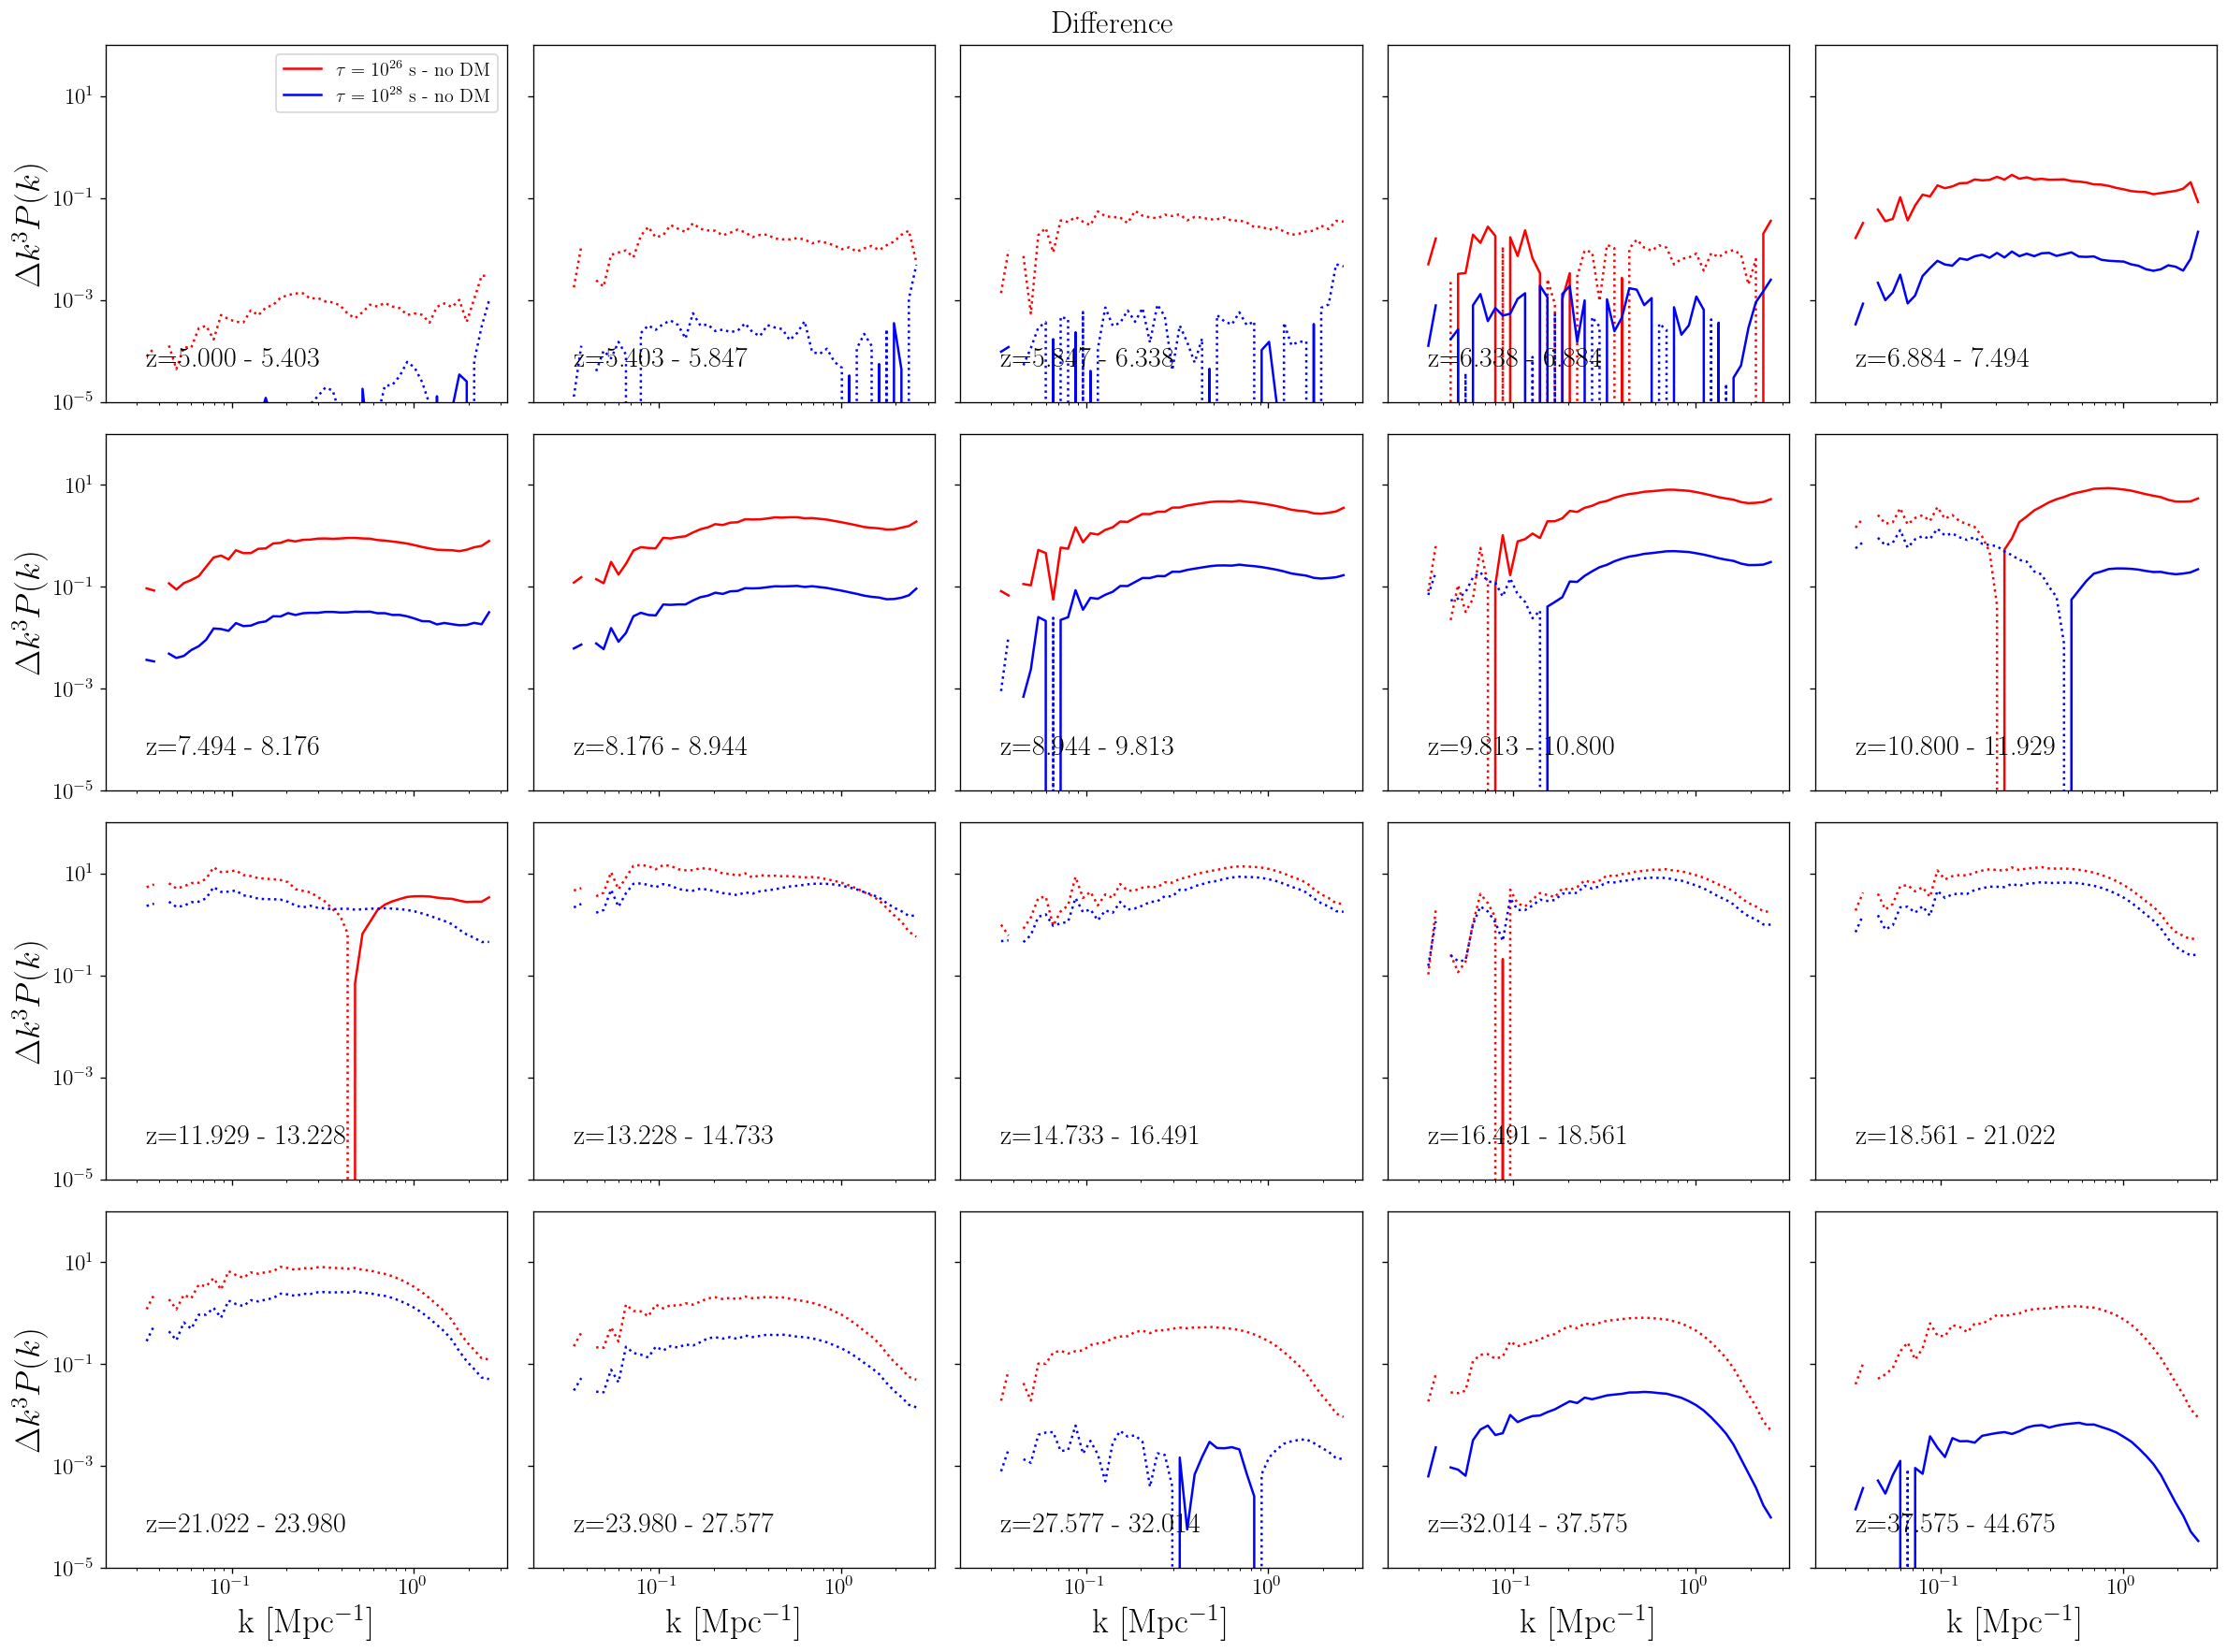

In [8]:
fig, axs = plt.subplots(4, 5, figsize = (20, 15), sharex = True, sharey = True)

chunk_inds = get_chunk_indices(lc_bkg, 20)
z_s = lc_bkg.lightcone_redshifts

for i, (ps, pss, psl) in enumerate(zip(ps_bkg, ps_small, ps_large)):
    ri, ci = np.unravel_index(i, axs.shape)
    ax = axs[ri, ci]
    ax.plot(psl['k'], psl['delta']-ps['delta'], color='r', label=r'$\tau=10^{26}$ s - no DM' if i==0 else None)
    ax.plot(psl['k'], -(psl['delta']-ps['delta']), color='r', ls=':')
    ax.plot(pss['k'], pss['delta']-ps['delta'], color='b', label=r'$\tau=10^{28}$ s - no DM' if i==0 else None)
    ax.plot(pss['k'], -(pss['delta']-ps['delta']), color='b', ls=':')
    ax.text(.1, .1, f'z={z_s[chunk_inds[i]]:.3f} - {z_s[chunk_inds[i+1]]:.3f}', transform=ax.transAxes, fontsize=18)

axs[0, 0].set(xscale='log', yscale='log', ylim=(1e-5, 1e2))
axs[0, 0].legend()

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel(r'k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel(r'$\Delta k^3 P(k)$', fontsize = 22)
    
fig.suptitle('Difference', fontsize=20)
fig.tight_layout()

## What is the typical distance in which a photon deposite its energy?

In [12]:
with h5py.File('../data/cooling_rates/cfdepth.h5', 'r') as f:
    cfdepth = f['cfdepth'][()]
    rs_s = f['rs_s'][()]
    Ep_s = f['Ep_s'][()]

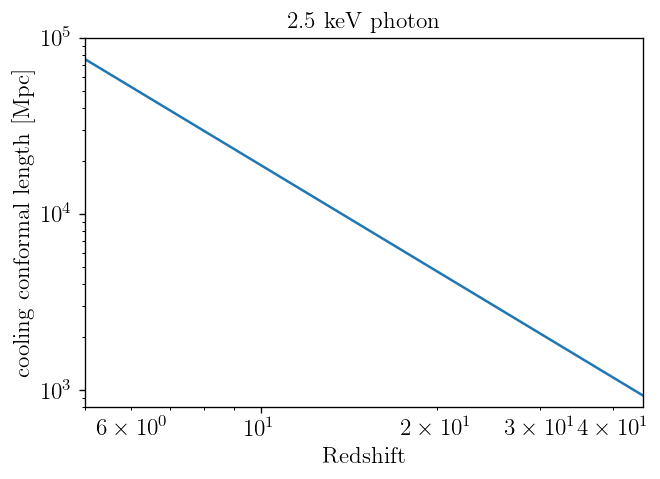

In [18]:
cfdepth_interp = interpolate.RectBivariateSpline(rs_s, Ep_s, np.log10(cfdepth))
Ep = 2.5e3

cfdepth_arr = 10**cfdepth_interp(rs_s, np.full_like(rs_s, Ep), grid=False)
fig, ax = plt.subplots()
ax.plot(rs_s, cfdepth_arr)
ax.set(xscale='log', yscale='log')
ax.set(xlim=(5, 45), ylim=(0.8e3, 1e5))
ax.set(xlabel='Redshift', ylabel='cooling conformal length [Mpc]', title='2.5 keV photon');